# Améliorez le produit IA de votre start-up

## Analyser les photos pour déterminer les catégories des photos 

## Création des labels des photos

### Importer la librairie

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
from matplotlib.image import imread
%pylab inline
import time, cv2
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
path = "C:/Users/JK253/Documents/Ingenieur IA/P6/photos/"
import json
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
import itertools
%matplotlib inline
tf.__version__

Populating the interactive namespace from numpy and matplotlib


C:\Users\JK253\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


'2.3.0'

In [2]:
data = pd.read_csv('../P6/P6_01_fichiercsv_photos_03_train.csv')

In [3]:
data

,label,label_num,fichiers_photo
0,drink,0,uq1qcV5kf36rjB1TP1GCLg.jpg
1,drink,0,ZW5jolpNvcUp-9WTDvflzA.jpg
2,drink,0,IGXvDVk-jO-Gf2kJSK430Q.jpg
3,drink,0,4jYV6b64iMhduZHP-gt--Q.jpg
4,drink,0,708W7D3giVuge7Qh38BHVQ.jpg
...,...,...,...
2495,food,2,mz57yXcVE4g32W7UuaUIQA.jpg
2496,food,2,TbyfSlEc45NGH-c2LxBgsg.jpg
2497,food,2,3mCg7Bh0u37WHNZclEFeyg.jpg
2498,food,2,w8p1cpRO0b167R4mauXiQQ.jpg


In [4]:
data.groupby("label_num").count()

,label,fichiers_photo
label_num,,
0,500,500
1,500,500
2,500,500
3,500,500
4,500,500


In [5]:
data.groupby("label").max().head()

,label_num,fichiers_photo
label,,
drink,0,zz4F6jQ7bpzrRWmtR9_soQ.jpg
food,2,zyyl2s6eWKXydxsGUTqMqw.jpg
interior,4,zvtRkAS4eBlKY_a75nq1bw.jpg
menu,1,zyz7zdej08AOsnrOGBBwJA.jpg
outside,3,zrPFwxc30ROkfkbihTF1ww.jpg


### Affichage d'exemples d'images par label

In [6]:
def list_fct(name) :
    list_image_name = [data['fichiers_photo'][i] for i in range(len(data)) if data["label"][i]==name]
    return list_image_name

list_drink=[data['fichiers_photo'][i] for i in range(len(data)) if data["label"][i]=="drink"]
list_food=[data['fichiers_photo'][i] for i in range(len(data)) if data["label"][i]=="food"]
list_interior=[data['fichiers_photo'][i] for i in range(len(data)) if data["label"][i]=="interior"]
list_menu=[data['fichiers_photo'][i] for i in range(len(data)) if data["label"][i]=="menu"]
list_outside=[data['fichiers_photo'][i] for i in range(len(data)) if data["label"][i]=="outside"]

for name in data["label"] :
    for i in range(3):
        #plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)

### Détermination et affichage des descripteurs SIFT

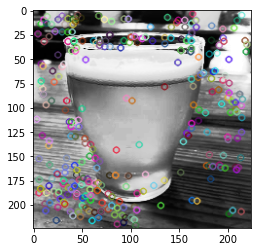

Descripteurs :  (339, 128)

[[ 19.   7.   0. ...  37.   0.   0.]
 [ 13.  41.  56. ...   0.   0.   0.]
 [  1.   0.   0. ...  19.  35.  30.]
 ...
 [ 14.  88.  30. ...  40.  19.   0.]
 [ 16.  50.  12. ...   0.   0.   1.]
 [111.  85.   0. ...   0.   1.   2.]]


In [7]:
sift = cv2.xfeatures2d.SIFT_create()
# Lire l’image et définir en échelle de gris
image = cv2.imread(path+data['fichiers_photo'][1], cv2.IMREAD_GRAYSCALE) 
# Redimensionner l’image à 224x224 px
image = cv2.resize(image, (224, 224))
# égaliser l’histogramme de l’image
image = cv2.equalizeHist(image) 
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

* L'image contient 339 descripteurs
* Chaque descripteur est un vecteur de longueur 128

### Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image

* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [8]:
# identification des points clés et des descripteurs associés
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create()

for image_num in range(len(data['fichiers_photo'])) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+data['fichiers_photo'][image_num],cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    res = cv2.equalizeHist(image)
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


<ipython-input-8-f7d270094248>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (1174107, 128)
temps de traitement SIFT descriptor :            32.83 secondes


## Création des clusters de descripteurs

* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [9]:
# Détermination du nombre de clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  1084
Création de 1084 clusters de descripteurs ...


C:\Users\JK253\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


temps de traitement kmeans :           131.55 secondes


## Création des features des images

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

**Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster**

In [10]:
# Création d’histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
temps de création histogrammes :            11.85 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [11]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (2500, 1084)
Dimensions dataset après réduction PCA :  (2500, 973)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [12]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)

(2500, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

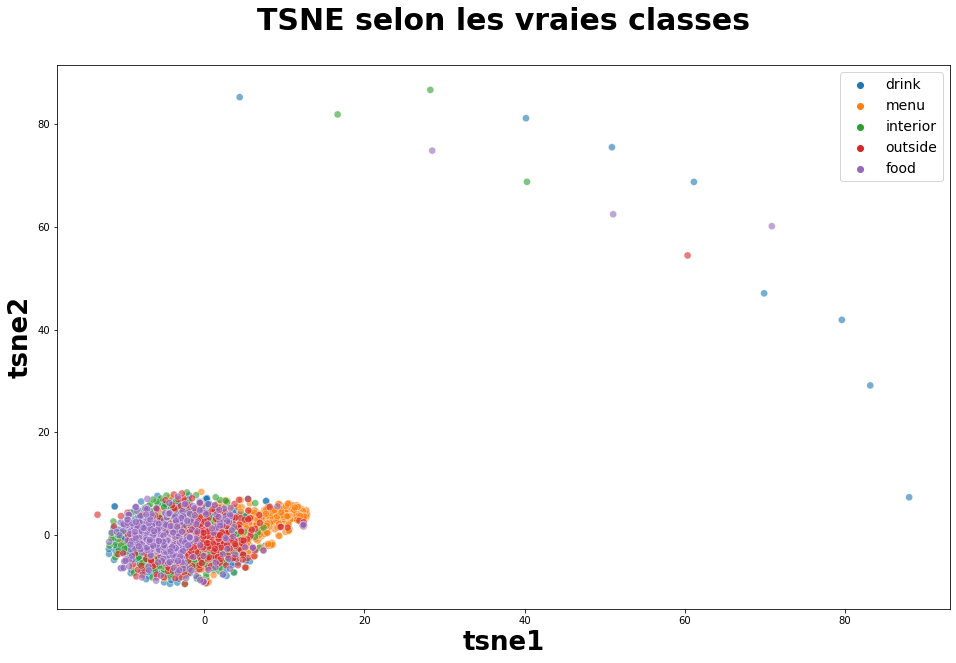

In [13]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

* Séparation partielle des classes food, outside et menu

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [14]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(2500, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

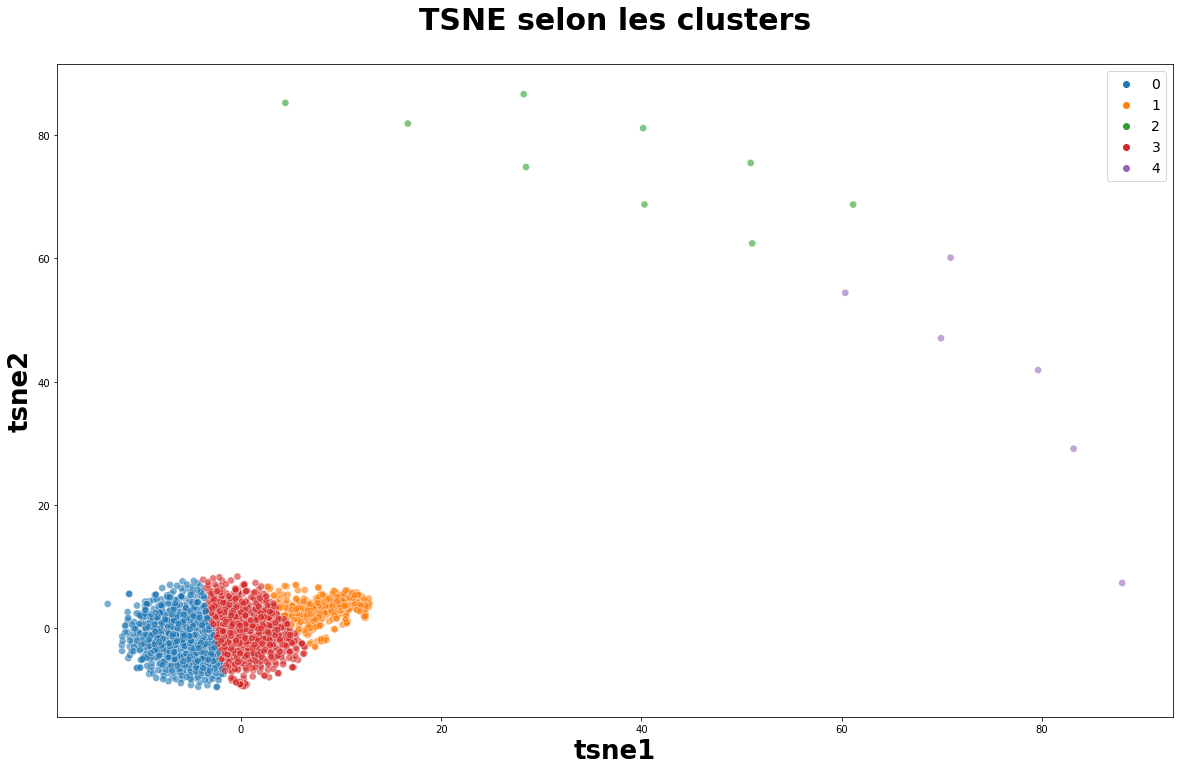

ARI :  0.149176616964482


In [15]:
plt.figure(figsize=(20,12))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* Le score ARI de 0.149 reste faible

### Analyse par classes
* La matrice de confusion doit être transformée pour permettre d'avoir en colonne le même ordre des catégories supposées qu'en ligne

In [16]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    1086
1     430
2       9
3     969
4       6
Name: class, dtype: int64

In [17]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[264  27   4 201   4]
 [ 25 358   0 117   0]
 [389   6   2 102   1]
 [155  29   0 315   1]
 [253  10   3 234   0]]


In [18]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [4, 1, 0, 3, 2]# Manuellement
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 1 0 3 0]
[[  8  27 264 201   0]
 [  0 358  25 117   0]
 [  3   6 389 102   0]
 [  1  29 155 315   0]
 [  3  10 253 234   0]]

              precision    recall  f1-score   support

           0       0.53      0.02      0.03       500
           1       0.83      0.72      0.77       500
           2       0.36      0.78      0.49       500
           3       0.33      0.63      0.43       500
           4       0.00      0.00      0.00       500

    accuracy                           0.43      2500
   macro avg       0.41      0.43      0.34      2500
weighted avg       0.41      0.43      0.34      2500



C:\Users\JK253\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JK253\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JK253\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
list_labels = ["drink", "menu", "interior", "outside","food"]

<AxesSubplot:>

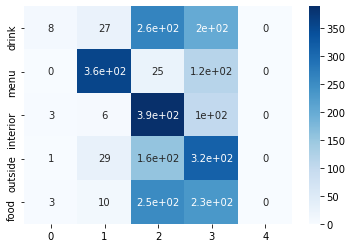

In [20]:
df_cm = pd.DataFrame(conf_mat, index = [label_name for label_name in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [21]:
df_cm.head()

,0,1,2,3,4
drink,8,27,264,201,0
menu,0,358,25,117,0
interior,3,6,389,102,0
outside,1,29,155,315,0
food,3,10,253,234,0


### Créer une dataframe de la nouvelle catègorie de photo (SIFT)

In [22]:
Cla_sift =pd.DataFrame({'fichiers_photo':data['fichiers_photo'][i],'label_num':cls_labels_transform})

In [23]:
Cla_sift['classe'] = Cla_sift['label_num'].map({
    0 :'drink',
    1 :'menu',
    2 :'interior',
    3 :'outside',
    4 :'food'
})

In [55]:
Cla_sift.head(5)

,fichiers_photo,label_num,classe
0,intol64X4_xBMmuQEary1A.jpg,2,interior
1,intol64X4_xBMmuQEary1A.jpg,1,menu
2,intol64X4_xBMmuQEary1A.jpg,2,interior
3,intol64X4_xBMmuQEary1A.jpg,3,outside
4,intol64X4_xBMmuQEary1A.jpg,3,outside


In [25]:
Cla_sift.groupby("classe").count()

,fichiers_photo,label_num
classe,,
drink,15,15
interior,1086,1086
menu,430,430
outside,969,969


### Sauvegarder le fichier en format CSV

In [26]:
Cla_sift.to_csv (r'P6_01_fichiercsv_photos_04_sift.csv', index = False, header=True)

## CNN Transfert Learning

Mettre en oeuvre une démarche de pré-traitement des images basée sur du CNN Transfer learning

### VGG-16

Utilisation du modèle VGG-16 de deep learning pré-entraîné sur des millions d'images

### Charger les images

In [27]:
train_datagen = ImageDataGenerator(
      rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_dataframe(dataframe=data, directory=path,
                                             x_col='fichiers_photo',
                                             y_col=None,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=100,
                                             shuffle=False,
                                             seed=42)

Found 2500 validated image filenames.


### Enlever la dernière couche du modèle

In [29]:
# Spécifier la taille des images
IMG_SHAPE = (224, 224,3)

In [30]:
# Créer le modéle
vgg16_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [31]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [32]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [33]:
vgg16_model.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 7, 7, 512) dtype=float32>

In [34]:
# Ajouter les couches de sorties
x = Flatten()(vgg16_model.output)
prediction = Dense(5000, activation='softmax')(x)

In [35]:
model = Model(inputs=vgg16_model.input, outputs=prediction)

In [36]:
y = model.predict(train_generator)

In [37]:
y.shape

(2500, 5000)

### Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [38]:
print("Dimensions dataset avant réduction PCA : ", y.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(y)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (2500, 5000)
Dimensions dataset après réduction PCA :  (2500, 1720)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [39]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)

(2500, 3)


### Analyse visuelle : affichage T-SNE selon catégories d'images

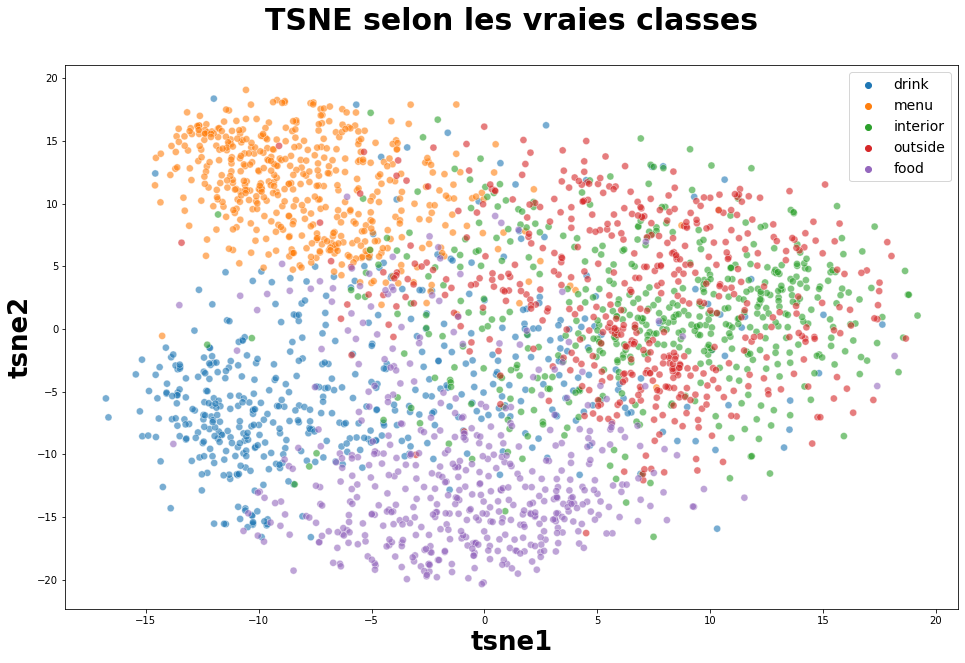

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

* On distingue mieu les séparations entre classe

### Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [41]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(2500, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

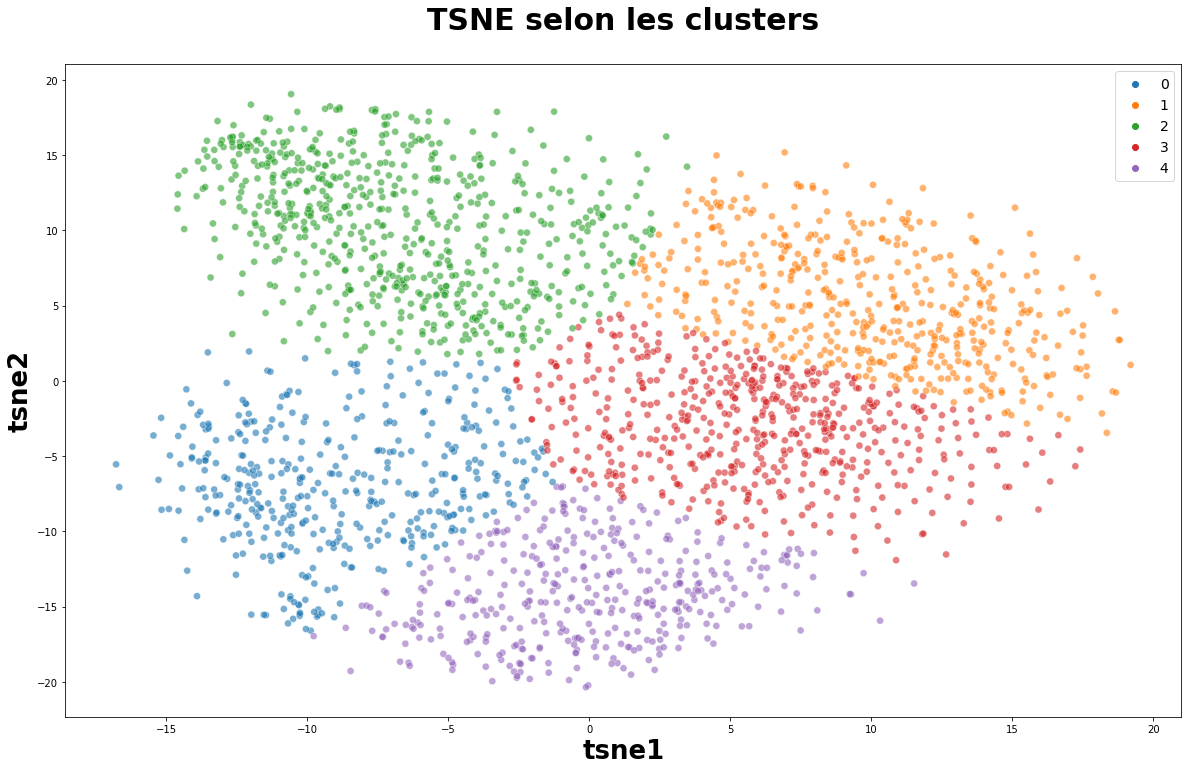

ARI :  0.4095655464016818


In [42]:
plt.figure(figsize=(20,12))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour permettre d'avoir en colonne le même ordre des catégories supposées qu'en ligne

In [43]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    413
1    487
2    663
3    545
4    392
Name: class, dtype: int64

In [44]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[321  17  44  97  21]
 [  1   6 489   4   0]
 [ 75   2  27  47 349]
 [  4 228  56 203   9]
 [ 12 234  47 194  13]]


In [45]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [4, 1, 0, 3, 2]# Manuellement
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 4 1 3 2]
[[321  44  21  97  17]
 [  1 489   0   4   6]
 [ 75  27 349  47   2]
 [  4  56   9 203 228]
 [ 12  47  13 194 234]]

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       500
           1       0.74      0.98      0.84       500
           2       0.89      0.70      0.78       500
           3       0.37      0.41      0.39       500
           4       0.48      0.47      0.47       500

    accuracy                           0.64      2500
   macro avg       0.65      0.64      0.64      2500
weighted avg       0.65      0.64      0.64      2500



In [46]:
list_labels = ["drink", "menu", "interior", "outside","food"]

<AxesSubplot:>

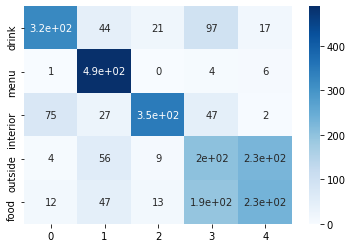

In [47]:
df_cm = pd.DataFrame(conf_mat, index = [label_name for label_name in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [48]:
df_cm.head()

,0,1,2,3,4
drink,321,44,21,97,17
menu,1,489,0,4,6
interior,75,27,349,47,2
outside,4,56,9,203,228
food,12,47,13,194,234


### Créer une dataframe de la nouvelle catègorie de photo (VGG16)

In [49]:
CNN_vgg16 =pd.DataFrame({'fichiers_photo':train_generator.filenames,'label_num':cls_labels_transform})

In [50]:
CNN_vgg16['classe'] = CNN_vgg16['label_num'].map({
    0 :'drink',
    1 :'menu',
    2 :'interior',
    3 :'outside',
    4 :'food'
})

In [56]:
CNN_vgg16.head(5)

,fichiers_photo,label_num,classe
0,uq1qcV5kf36rjB1TP1GCLg.jpg,0,drink
1,ZW5jolpNvcUp-9WTDvflzA.jpg,0,drink
2,IGXvDVk-jO-Gf2kJSK430Q.jpg,0,drink
3,4jYV6b64iMhduZHP-gt--Q.jpg,3,outside
4,708W7D3giVuge7Qh38BHVQ.jpg,1,menu


In [57]:
CNN_vgg16.groupby("classe").count()

,fichiers_photo,label_num
classe,,
drink,413,413
food,487,487
interior,392,392
menu,663,663
outside,545,545


### Sauvegarder le fichier en format CSV

In [53]:
CNN_vgg16.to_csv (r'P6_01_fichiercsv_photos_05_cnn.csv', index = False, header=True)